In [68]:
import pandas as pd
from glob import glob
from tqdm import tqdm
from transformers import pipeline
from datetime import datetime

import re
import os
import twint
import nest_asyncio
import datetime
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

nest_asyncio.apply()
tqdm.pandas()

# Web Scraping de Tweets

In [69]:
capitales = pd.read_excel('datasets/CAPITALES_departamentos.xlsx')

In [153]:
c = twint.Config()

c.Search = 'gustavo petro OR @petrogustavo OR petro'

start = datetime.datetime(2022, 3, 1)
end = datetime.datetime(2022, 6, 18)

for capital in tqdm(capitales['Capital']):   
    c.Limit=4000
    c.Since = str(start)
    c.Until = str(end)
    c.Store_csv = True       # store tweets in a csv file
    c.Near = capital
    c.Language = 'es'
    c.Output = "datasets/raw/gustavo_petro/{}.csv".format(capital)
    c.Hide_output = True

    twint.run.Search(c)


100%|██████████| 33/33 [00:42<00:00,  1.30s/it]

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


In [154]:
c = twint.Config()

c.Search = 'rodolfo hernandez OR @ingrodolfohdez OR @ligagobernantes'

start = datetime.datetime(2022, 3, 1)
end = datetime.datetime(2022, 6, 18)

for capital in tqdm(capitales['Capital']):   
    c.Limit=6000
    c.Since = str(start)
    c.Until = str(end)
    c.Store_csv = True       # store tweets in a csv file
    c.Near = capital
    c.Language = 'es'
    c.Output = "datasets/raw/rodolfo_hernandez/{}.csv".format(capital)
    c.Hide_output = True

    twint.run.Search(c)

  9%|▉         | 3/33 [00:02<00:26,  1.13it/s]

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


 48%|████▊     | 16/33 [00:21<00:21,  1.24s/it]

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


100%|██████████| 33/33 [00:43<00:00,  1.31s/it]

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


Consolidación de todos los archivos generados por departamento en un solo archivo de Tweets por candidato.

In [ ]:
petro_files = glob('datasets/raw/gustavo_petro/*.csv')
df_petro = pd.read_csv(petro_files[0])
df_petro['capital'] = petro_files[0].split('\\')[-1].split('.')[0]

for file in tqdm(petro_files[1:]):
    capital = file.split('\\')[-1].split('.')[0]
    df_petro_tmp = pd.read_csv(file)
    df_petro_tmp['capital'] = capital
    df_petro = pd.concat([df_petro, df_petro_tmp])

df_petro.drop_duplicates().to_csv('datasets/raw/gustavo_petro_tweets.csv')
print(len([os.remove(x) for x in petro_files]))

100%|██████████| 30/30 [00:02<00:00, 10.10it/s]


31


In [ ]:
rodolfo_files = glob('datasets/raw/rodolfo_hernandez/*.csv')
df_rodolfo = pd.read_csv(rodolfo_files[0])
df_rodolfo['capital'] = rodolfo_files[0].split('\\')[-1].split('.')[0]

for file in tqdm(rodolfo_files[1:]):
    capital = file.split('\\')[-1].split('.')[0]
    df_rodolfo_tmp = pd.read_csv(file)
    df_rodolfo_tmp['capital'] = capital
    df_rodolfo = pd.concat([df_rodolfo, df_rodolfo_tmp])

df_rodolfo.drop_duplicates().to_csv('datasets/raw/rodolfo_hernandez_tweets.csv')
print(len([os.remove(x) for x in rodolfo_files]))

100%|██████████| 28/28 [00:02<00:00, 12.99it/s]


29


# Analisis de sentimientos

Generar la etiqueta para cada tweet con base en el sentimiento generado por el Pipeline de Hugging Face.

In [ ]:
sentiment_pipeline = pipeline(model = "sagorsarker/codeswitch-spaeng-sentiment-analysis-lince")

df_tweets_petro = pd.read_csv('datasets/raw/gustavo_petro_tweets.csv')
df_tweets_petro['candidato'] = 'petro'

df_tweets_rodolfo = pd.read_csv('datasets/raw/rodolfo_hernandez_tweets.csv')
df_tweets_rodolfo['candidato'] = 'rodolfo'

min_values = {}
for capital in capitales['Capital']:
    min_r = len(df_tweets_rodolfo[df_tweets_rodolfo['capital']==capital])
    min_p = len(df_tweets_petro[df_tweets_petro['capital']==capital])
    min_values[capital] = np.min([min_r, min_p])

df_tweets_petro = df_tweets_petro.groupby(['capital'], as_index=False, group_keys=False).apply(lambda x: x.sample(min(4000, min_values[x['capital'].values[0]])))
df_tweets = pd.concat([df_tweets_petro, df_tweets_rodolfo])

def preprocess_string(text):
    p_text = ' '.join([x for x in text.split() if '@' not in x and '#' not in x])
    return p_text

df_tweets = df_tweets[[x for x in df_tweets.columns if 'unnamed' not in x.lower()]]
df_tweets['tweet_p'] = df_tweets['tweet'].progress_apply(lambda x: preprocess_string(x))
df_tweets['label'] = df_tweets['tweet_p'].progress_apply(lambda x: sentiment_pipeline(x)[0]['label'])

df_tweets = df_tweets[[x for x in df_tweets.columns if 'unnamed' not in x.lower()]]
df_tweets_es = df_tweets[df_tweets['language'] == 'es']
df_tweets_es = df_tweets_es.drop_duplicates()

file_path = 'datasets/tweets_candidatos_procesados_codeswitch-spaeng-sentiment-analysis-lince.csv'
df_tweets_es.to_csv(file_path)

Downloading: 100%|██████████| 1.26k/1.26k [00:00<00:00, 213kB/s]
Downloading: 100%|██████████| 704/704 [00:00<00:00, 238kB/s]
Downloading: 100%|██████████| 679M/679M [10:37<00:00, 1.12MB/s]   
Downloading: 100%|██████████| 49.0/49.0 [00:00<00:00, 12.2kB/s]
Downloading: 100%|██████████| 972k/972k [00:03<00:00, 284kB/s]  
Downloading: 100%|██████████| 112/112 [00:00<00:00, 37.3kB/s]
C:\Users\DanielBaron\AppData\Local\Temp\ipykernel_28216\1678890586.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tweets_petro = pd.read_csv('datasets/raw/gustavo_petro_tweets.csv')
100%|██████████| 54961/54961 [1:56:32<00:00,  7.86it/s]  


# Extracción del Support rate por usuario

In [80]:
def get_home_location(df, user):
    """
    Función utilizada para calcular el home location de cada usuario. Si el usuario tiene tweets en mas de una ubicación, se toma los que hayan sido escritos 
    en un horario de 8 pm a 8 am.
    """
    df = df[df['username']==user]
    df_night_hour = df[df['time'].between(datetime.datetime.strptime('20:00:00',"%H:%M:%S").time(), datetime.datetime.strptime('08:00:00',"%H:%M:%S").time())]

    if len(df_night_hour)>1:
        home_location = df_night_hour['departamento'].value_counts().reset_index().head(1)['index'].values[0]
    else:
        home_location = df['departamento'].value_counts().reset_index().head(1)['index'].values[0]
    
    return home_location

def decode_label_3c(label):
    """
    Función usada para decodificar la salida del pipeline de Hugging Face. En este caso el modelo retornaba 3 etiquetas (positivo, neutro y negativo).
    """
    if label == 'NEU':
        d_label = 1
    elif label == 'NEG':
        d_label = 0
    elif label == 'POS':
        d_label = 2
    return d_label

def decode_label_2c(label):
    """
    Función usada para decodificar la salida del pipeline de Hugging Face. En este caso el modelo retornaba 2 etiquetas (positivo y negativo).
    """
    if label == 'LABEL_1':
        d_label = 1
    elif label == 'LABEL_0':
        d_label = 0
    return d_label

def get_candidate(df, user):
    """
    Función usada para calcular el support rate de cada usuario a cada candidato. Se hace el promedio de los tweets por candidato para cada usuario y se restan
    el support rate de Petro y el de Rodolfo. Si el valor de la resta es mayor a 0 indica que el usuario apoya mas a Petro que a Rodolfo. Si el valor de la resta
    es menor a 0 indica que el usuario apoya mas a Rodolfo que a Petro. No se encontró ningun caso en donde haya un valor igual a 0.
    """
    df = df[df['username']==user]
    candidatos = {key: 0 for key in ['petro', 'rodolfo']}
    for candidato in df['candidato'].drop_duplicates():
        candidatos[candidato] = np.mean(df[df['candidato'] == candidato]['label'])

    if candidatos['petro']-candidatos['rodolfo']>0:
        return 'petro'
    elif candidatos['petro']-candidatos['rodolfo']<0:
        return 'rodolfo'

In [150]:
file_path = 'datasets/tweets_candidatos_procesados_robertuito-sentiment-analysis.csv'

df_tweets_es = pd.read_csv(file_path, index_col=[0])

Generación de la gráfica de sentimiento por día para cada candidato. Se resaltan algunas fechas importantes en el intervalo de tiempo analizado.

100%|██████████| 25883/25883 [00:00<00:00, 231106.60it/s]


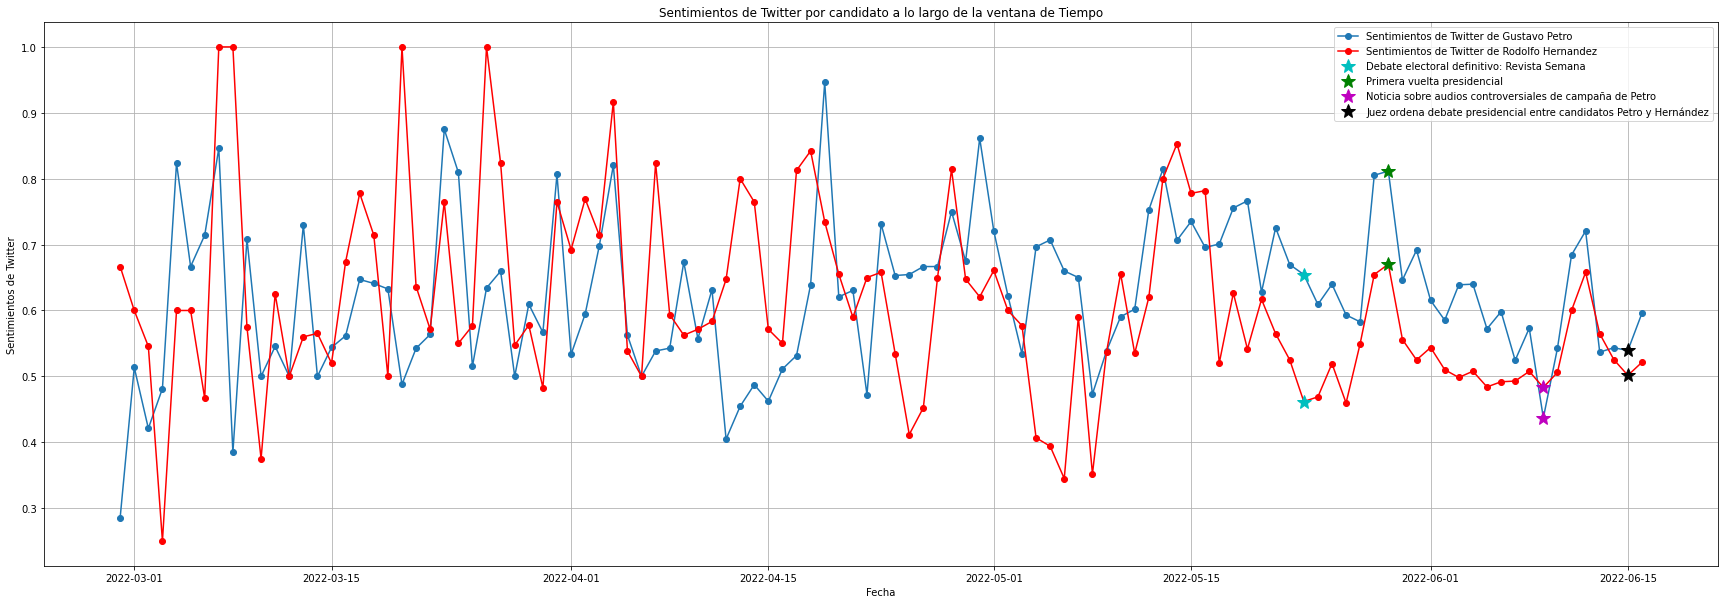

In [151]:
tweets_petro = df_tweets_es[df_tweets_es['candidato']=='petro'][['date', 'label']]
try:
    tweets_petro['label'] = tweets_petro['label'].progress_apply(lambda x: decode_label_3c(x))
except:
    tweets_petro['label'] = tweets_petro['label'].progress_apply(lambda x: decode_label_2c(x))
tweets_petro = tweets_petro.groupby('date').agg('mean').reset_index()
tweets_petro['date'] = matplotlib.dates.date2num(pd.to_datetime(tweets_petro['date']))
tweets_petro = tweets_petro.sort_values(by='date')

tweets_rodolfo = df_tweets_es[df_tweets_es['candidato']=='rodolfo'][['date', 'label']]
try:
    tweets_rodolfo['label'] = tweets_rodolfo['label'].progress_apply(lambda x: decode_label_3c(x))
except:
    tweets_rodolfo['label'] = tweets_rodolfo['label'].progress_apply(lambda x: decode_label_2c(x))

tweets_rodolfo = tweets_rodolfo.groupby('date').agg('mean').reset_index()
tweets_rodolfo['date'] = matplotlib.dates.date2num(pd.to_datetime(tweets_rodolfo['date']))
tweets_rodolfo = tweets_rodolfo.sort_values(by='date')

fecha_debate_r = matplotlib.dates.date2num(datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'))
tweets_fecha_debate_r = tweets_rodolfo[tweets_rodolfo['date']==fecha_debate_r]['label'].values[0]
fecha_primera_vuelta_r = matplotlib.dates.date2num(datetime.datetime.strptime('2022-05-29', '%Y-%m-%d'))
tweets_fecha_primera_vuelta_r = tweets_rodolfo[tweets_rodolfo['date']==fecha_primera_vuelta_r]['label'].values[0]
fecha_audios_campaña_petro_r = matplotlib.dates.date2num(datetime.datetime.strptime('2022-06-09', '%Y-%m-%d'))
tweets_fecha_audios_campaña_petro_r = tweets_rodolfo[tweets_rodolfo['date']==fecha_audios_campaña_petro_r]['label'].values[0]
fecha_debate_juez_r = matplotlib.dates.date2num(datetime.datetime.strptime('2022-06-15', '%Y-%m-%d'))
tweets_fecha_debate_juez_r = tweets_rodolfo[tweets_rodolfo['date']==fecha_debate_juez_r]['label'].values[0]

fecha_debate_p = matplotlib.dates.date2num(datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'))
tweets_fecha_debate_p = tweets_petro[tweets_petro['date']==fecha_debate_p]['label'].values[0]
fecha_primera_vuelta_p = matplotlib.dates.date2num(datetime.datetime.strptime('2022-05-29', '%Y-%m-%d'))
tweets_fecha_primera_vuelta_p = tweets_petro[tweets_petro['date']==fecha_primera_vuelta_p]['label'].values[0]
fecha_audios_campaña_petro_p = matplotlib.dates.date2num(datetime.datetime.strptime('2022-06-09', '%Y-%m-%d'))
tweets_fecha_audios_campaña_petro_p = tweets_petro[tweets_petro['date']==fecha_audios_campaña_petro_p]['label'].values[0]
fecha_debate_juez_p = matplotlib.dates.date2num(datetime.datetime.strptime('2022-06-15', '%Y-%m-%d'))
tweets_fecha_debate_juez_p = tweets_petro[tweets_petro['date']==fecha_debate_juez_p]['label'].values[0]

plt.figure(figsize=(30,10))
plt.plot_date(tweets_petro['date'], tweets_petro['label'], '-o')
plt.plot_date(tweets_rodolfo['date'], tweets_rodolfo['label'], '-or')
plt.xlabel('Fecha')
plt.ylabel('Sentimientos de Twitter')
plt.title('Sentimientos de Twitter por candidato a lo largo de la ventana de Tiempo')
plt.grid()
plt.plot(fecha_debate_r, tweets_fecha_debate_r, '*c', markersize=15)
plt.plot(fecha_primera_vuelta_r, tweets_fecha_primera_vuelta_r, '*g', markersize=15)
plt.plot(fecha_audios_campaña_petro_r, tweets_fecha_audios_campaña_petro_r, '*m', markersize=15)
plt.plot(fecha_debate_juez_r, tweets_fecha_debate_juez_r, '*k', markersize=15)

plt.plot(fecha_debate_p, tweets_fecha_debate_p, '*c', markersize=15)
plt.plot(fecha_primera_vuelta_p, tweets_fecha_primera_vuelta_p, '*g', markersize=15)
plt.plot(fecha_audios_campaña_petro_p, tweets_fecha_audios_campaña_petro_p, '*m', markersize=15)
plt.plot(fecha_debate_juez_p, tweets_fecha_debate_juez_p, '*k', markersize=15)
plt.legend(['Sentimientos de Twitter de Gustavo Petro', 'Sentimientos de Twitter de Rodolfo Hernandez', 'Debate electoral definitivo: Revista Semana', 
            'Primera vuelta presidencial', 'Noticia sobre audios controversiales de campaña de Petro', 'Juez ordena debate presidencial entre candidatos Petro y Hernández'])


Generación de la gráfica de tweets por día. Como en el caso anterior, se tomaron algunas fechas importantes en el intervalo de tiempo analizado.

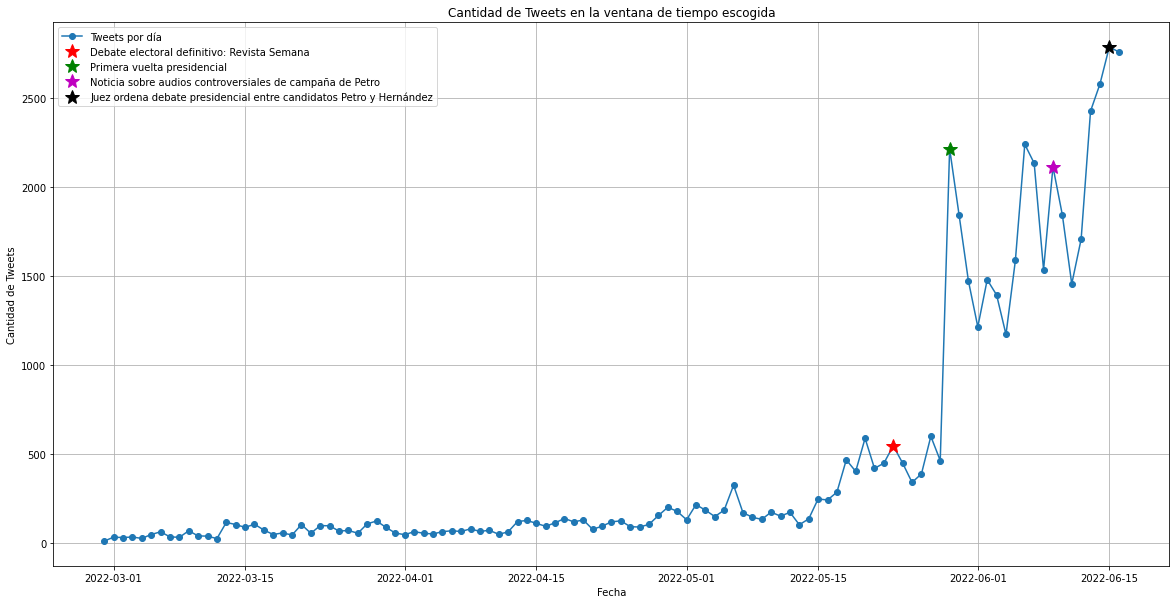

In [83]:
tweets_day = df_tweets_es[['date']].value_counts().reset_index()
tweets_day.columns = ['date', 'cantidad']
tweets_day['date'] = matplotlib.dates.date2num(pd.to_datetime(tweets_day['date']))
tweets_day = tweets_day.sort_values(by='date')

fecha_debate = matplotlib.dates.date2num(datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'))
tweets_fecha_debate = tweets_day[tweets_day['date']==fecha_debate]['cantidad'].values[0]
fecha_primera_vuelta = matplotlib.dates.date2num(datetime.datetime.strptime('2022-05-29', '%Y-%m-%d'))
tweets_fecha_primera_vuelta = tweets_day[tweets_day['date']==fecha_primera_vuelta]['cantidad'].values[0]
fecha_audios_campaña_petro = matplotlib.dates.date2num(datetime.datetime.strptime('2022-06-09', '%Y-%m-%d'))
tweets_fecha_audios_campaña_petro = tweets_day[tweets_day['date']==fecha_audios_campaña_petro]['cantidad'].values[0]
fecha_debate_juez = matplotlib.dates.date2num(datetime.datetime.strptime('2022-06-15', '%Y-%m-%d'))
tweets_fecha_debate_juez = tweets_day[tweets_day['date']==fecha_debate_juez]['cantidad'].values[0]

plt.figure(figsize=(20,10))
plt.plot_date(tweets_day['date'], tweets_day['cantidad'], '-o')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Tweets')
plt.title('Cantidad de Tweets en la ventana de tiempo escogida')
plt.grid()
plt.plot(fecha_debate, tweets_fecha_debate, '*r', markersize=15)
plt.plot(fecha_primera_vuelta, tweets_fecha_primera_vuelta, '*g', markersize=15)
plt.plot(fecha_audios_campaña_petro, tweets_fecha_audios_campaña_petro, '*m', markersize=15)
plt.plot(fecha_debate_juez, tweets_fecha_debate_juez, '*k', markersize=15)
plt.legend(['Tweets por día', 'Debate electoral definitivo: Revista Semana', 'Primera vuelta presidencial', 'Noticia sobre audios controversiales de campaña de Petro',\
    'Juez ordena debate presidencial entre candidatos Petro y Hernández'])

Extracción de las features utilizadas para construir los modelos.

In [115]:
df_tweets_def = df_tweets_es[['id', 'date', 'time', 'user_id', 'username', 'tweet', 'capital', 'candidato', 'label']]
df_tweets_def = df_tweets_def.merge(capitales, left_on='capital', right_on='Capital', how='left')
df_tweets_def = df_tweets_def.drop('Capital', axis=1).rename({'Departamento':'departamento'}, axis=1)
df_tweets_def['label'] = df_tweets_def['label'].progress_apply(lambda x: decode_label_3c(x))
df_tweets_def['time'] = df_tweets_def['time'].apply(lambda x: datetime.datetime.strptime(x,"%H:%M:%S").time())

100%|██████████| 48865/48865 [00:00<00:00, 297951.62it/s]


Calculo del support rate por usuario.

In [116]:
support_rate_user = []
for usuario in tqdm(df_tweets_def['username'].drop_duplicates()):
    home_location = get_home_location(df_tweets_def, usuario)
    candidato = get_candidate(df_tweets_def, usuario)
    support_rate_user.append([usuario, home_location, candidato])

df_support_rate_user = pd.DataFrame(data = support_rate_user, columns=['USUARIO', 'UBICACION', 'CANDIDATO'])

100%|██████████| 7602/7602 [02:48<00:00, 44.99it/s]


In [117]:
df_pib = pd.read_excel('datasets/economical_variables/PIB_departamentos.xlsx')
df_tasa_desempleo = pd.read_excel('datasets/economical_variables/TASA_DESEMPLEO_departamentos.xlsx').fillna(0)
df_elecciones_2022 = pd.read_excel('datasets/resultados_elecciones_2022.xlsx')

Calculo del support rate por departamento y candidato.

In [118]:
df_elecciones_2022[['petro', 'rodolfo']] = df_elecciones_2022[['petro', 'rodolfo']]/100
df_pib['tasa_aumento_pib'] = (df_pib['2021pr']-df_pib['2020p'])/df_pib['2020p']
df_tasa_desempleo['tasa_aumento_desempleo'] = ((df_tasa_desempleo[2021] - df_tasa_desempleo[2020])/df_tasa_desempleo[2020]).fillna(0)
df_support_rate = df_support_rate_user.groupby(by=['UBICACION', 'CANDIDATO']).agg('count').reset_index()
df_variables = df_support_rate.merge(df_pib[['DEPARTAMENTOS', 'tasa_aumento_pib']], left_on='UBICACION', right_on='DEPARTAMENTOS', how='left')
df_variables = df_variables.merge(df_tasa_desempleo[['DEPARTAMENTO', 'tasa_aumento_desempleo']], left_on='UBICACION', right_on='DEPARTAMENTO', how='left')
df_variables = df_variables[['UBICACION', 'CANDIDATO', 'USUARIO', 'tasa_aumento_pib', 'tasa_aumento_desempleo']]

In [125]:
candidato_support_rate = 'rodolfo'
df_variables = df_variables.merge(df_variables[['UBICACION', 'USUARIO']].groupby(by=['UBICACION']).agg('sum').reset_index(), on='UBICACION', how='left')
df_variables = df_variables[df_variables['CANDIDATO'] == candidato_support_rate]
col_name_support = 'support_rate_{}'.format(candidato_support_rate)
df_variables[col_name_support] = df_variables['USUARIO_x']/df_variables['USUARIO_y']
df_variables = df_variables[['UBICACION', col_name_support, 'tasa_aumento_pib', 'tasa_aumento_desempleo']].drop_duplicates().fillna(0)
df_variables.columns = ['ubicacion', col_name_support, 'tasa_aumento_pib', 'tasa_aumento_desempleo']

In [126]:
df_variables_def = df_variables.merge(df_elecciones_2022[['ubicacion', candidato_support_rate]], on='ubicacion', how='left')
df_variables_def = df_variables_def.rename({candidato_support_rate:col_name_support + '_real'}, axis=1)

In [129]:
df_variables_def.to_csv('datasets/variables_procesadas_bert_BetoSentimentAnalysis.csv')